<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

### Imports

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [2]:
# Check version (always a good idea for gensim)
gensim.__version__

'3.8.1'

### Get the Data

In [5]:
path = '/Users/Neal/Documents/Lambda_Classnotes'

In [19]:
df = pd.read_csv(path+'/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [20]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


### Tokenize

In [9]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [21]:
df['tokens'] = df['reviews.text'].apply(tokenizer)

In [22]:
df['tokens'].head()

0    (I, order, 3, of, them, and, one, of, the, ite...
1    (Bulk, is, always, the, less, expensive, way, ...
2    (Well, they, are, not, Duracell, but, for, the...
3    (Seem, to, work, as, well, as, name, brand, ba...
4    (These, batteries, are, very, long, lasting, t...
Name: tokens, dtype: object

In [23]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [24]:
df['tokens'].head()

0    [order, 3, item, bad, quality., missing, backu...
1               [bulk, expensive, way, products, like]
2                            [duracell, price, happy.]
3              [work, brand, batteries, better, price]
4            [batteries, long, lasting, price, great.]
Name: tokens, dtype: object

### Lemmas

In [25]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [27]:
df['lemmas'] = df['reviews.text'].apply(get_lemmas)

In [28]:
df['lemmas'].head()

0    [order, 3, item, bad, quality, miss, backup, s...
1                [bulk, expensive, way, product, like]
2                             [Duracell, price, happy]
3                  [work, brand, battery, well, price]
4                  [battery, long, last, price, great]
Name: lemmas, dtype: object

### Gensim LDA

In [29]:
id2word = corpora.Dictionary(df['lemmas'])

In [30]:
id2word.token2id['battery']

4

In [31]:
len(id2word.keys())

9706

In [32]:
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [33]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=12
                  )

In [34]:
lda.print_topics()

[(0,
  '0.066*"read" + 0.050*"book" + 0.026*"Kindle" + 0.026*"easy" + 0.022*"use" + 0.021*"love" + 0.020*"reader" + 0.019*"light" + 0.017*"enjoy" + 0.016*"screen"'),
 (1,
  '0.031*"8" + 0.027*"Fire" + 0.023*"tablet" + 0.018*"great" + 0.016*"screen" + 0.015*"HD" + 0.015*"7" + 0.011*"Amazon" + 0.011*"new" + 0.011*"purchase"'),
 (2,
  '0.054*"love" + 0.036*"tablet" + 0.033*"buy" + 0.032*"daughter" + 0.032*"use" + 0.022*"easy" + 0.018*"watch" + 0.017*"kid" + 0.014*"old" + 0.014*"case"'),
 (3,
  '0.065*"tablet" + 0.032*"great" + 0.021*"well" + 0.019*"price" + 0.019*"good" + 0.015*"fire" + 0.013*"kindle" + 0.012*"recommend" + 0.012*"7" + 0.011*"keep"'),
 (4,
  '0.047*"kid" + 0.044*"app" + 0.038*"tablet" + 0.025*"great" + 0.021*"use" + 0.017*"like" + 0.017*"love" + 0.015*"child" + 0.013*"year" + 0.011*"lot"'),
 (5,
  '0.047*"great" + 0.040*"tablet" + 0.021*"Amazon" + 0.018*"use" + 0.016*"app" + 0.014*"need" + 0.013*"price" + 0.012*"love" + 0.011*"movie" + 0.010*"Google"'),
 (6,
  '0.131*"love

In [35]:
# Prettier output
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
read book Kindle easy use

------ Topic 1 ------
8 Fire tablet great screen

------ Topic 2 ------
love tablet buy daughter use

------ Topic 3 ------
tablet great well price good

------ Topic 4 ------
kid app tablet great use

------ Topic 5 ------
great tablet Amazon use app

------ Topic 6 ------
love old buy year Christmas

------ Topic 7 ------
battery work Amazon buy good

------ Topic 8 ------
time old Kindle love year

------ Topic 9 ------
battery long brand great price

------ Topic 10 ------
kindle love fire buy like

------ Topic 11 ------
good great price tablet nice

------ Topic 12 ------
great work buy tablet Amazon

------ Topic 13 ------
easy use great old tablet

------ Topic 14 ------
tablet buy good great game



### Check for best number of topics

In [38]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    num = 1
    
    for iter_ in range(passes):  # Maybe add a print statement to check the progress as it runs
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
        print(f"pass {num} complete.")
        num += 1

    return coherence_values

In [39]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            start=2, 
                                            limit=40, 
                                            step=2,
                                            passes=10)


2 topics done.
4 topics done.
6 topics done.
8 topics done.
10 topics done.
12 topics done.
14 topics done.
16 topics done.
18 topics done.
20 topics done.


In [40]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [41]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.390265
1,0,4,-2.421310
2,0,6,-2.374726
3,0,8,-2.395505
4,0,10,-2.458958


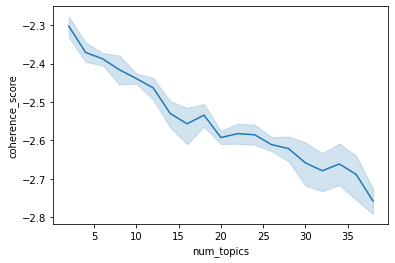

In [42]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

### From the graph it appears that the number of topics should be 18. ???

In [46]:
# Print the coherence scores
for m, cv in zip(topic_coherence["num_topics"], topic_coherence['coherence_score']):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -2.3903
Num Topics = 4  has Coherence Value of -2.4213
Num Topics = 6  has Coherence Value of -2.3747
Num Topics = 8  has Coherence Value of -2.3955
Num Topics = 10  has Coherence Value of -2.459
Num Topics = 12  has Coherence Value of -2.453
Num Topics = 14  has Coherence Value of -2.5315
Num Topics = 16  has Coherence Value of -2.5162
Num Topics = 18  has Coherence Value of -2.4799
Num Topics = 20  has Coherence Value of -2.5501
Num Topics = 22  has Coherence Value of -2.544
Num Topics = 24  has Coherence Value of -2.607
Num Topics = 26  has Coherence Value of -2.6142
Num Topics = 28  has Coherence Value of -2.6
Num Topics = 30  has Coherence Value of -2.6146
Num Topics = 32  has Coherence Value of -2.6161
Num Topics = 34  has Coherence Value of -2.6742
Num Topics = 36  has Coherence Value of -2.6248
Num Topics = 38  has Coherence Value of -2.792
Num Topics = 2  has Coherence Value of -2.2764
Num Topics = 4  has Coherence Value of -2.3816
Num To

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling